In [1]:
import GenEvents as ge
import PlotEvents as pe
import EventData as ed
import Params as ps

In [2]:
import numpy as np
import tqdm 
import math

import snntorch as snn
import torch
import torch.nn as nn

import snntorch.spikeplot as splt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from snntorch import surrogate
import snntorch.functional as SF

from snntorch import spikegen

import matplotlib.pyplot as plt
import snntorch.spikeplot as splt

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
num_events = 10000
num_events_test = 2000

events_arr, muon_list, max_n = ge.generate_noisy_evts(num_events, noise_frac=0.4, bkg_frac=0.5)
events_arr_test, muon_list_test, max_n_test = ge.generate_noisy_evts(num_events_test, noise_frac=0.4, bkg_frac=0.5)

100%|██████████████████████████████████████████| 2000/2000 [00:01<00:00, 1214.46it/s]


In [15]:
def find_trueHits(muon_list,target_dtype=np.int16):
    target_list=[]
    
    for event in muon_list:
        target_event=[]
        for hit in event:
            
            if hit["signal"] == True:
                target_event.append(hit)
        
        target_list.append(target_event)
        
    return target_list

target_list = find_trueHits(muon_list)
target_list_test = find_trueHits(muon_list_test)

In [16]:
# transform each event (muon_hits list) to np.array of fixed size
def convert_to(muon_list, size, target_dtype=np.int16,
               features=['layer', 'wire_num', 'bx', 't0']):
    padded_array = np.zeros(shape=(len(muon_list), size, len(features)), dtype=target_dtype)
    for i, muon_hits in enumerate(muon_list):
        for j, hit in enumerate(muon_hits):
            for k, f in enumerate(features):
                padded_array[i,j,k] = hit[f]  # BEWARE: implicit type conversions going on here

    return padded_array



feature_list = ['layer', 'wire_num', 'bx', 't0', 'signal']
muon_array = convert_to(muon_list, size=max_n, target_dtype=np.float32,
                        features=feature_list)
test_array = convert_to(muon_list_test, size=max_n_test, target_dtype=np.float32,
                        features=feature_list)

target_array = convert_to(target_list, size=max_n, target_dtype=np.float32,
                        features=feature_list)
target_test_array = convert_to(target_list_test, size=max_n_test, target_dtype=np.float32,
                        features=feature_list)

In [21]:
class CustomDataset(Dataset):
    def __init__(self, input_data, target):
        
        self.data = input_data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': torch.tensor(self.data[idx],dtype=torch.float32), 
                  'target': torch.tensor(self.target[idx],dtype=torch.float32)}  
        return sample
    
train_dataset = CustomDataset(muon_array, target_array)
test_dataset = CustomDataset(test_array, target_test_array)

In [120]:
batch_size = 100
nw=0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)

In [121]:
def custom_spikegen(data, num_step=40):
    
    spike_data = torch.zeros(size=(num_step,batch_size,ps.NLAYERS,ps.NWIRES))
    for n_batch, evt in enumerate(data):
    
        notZeroBx = evt[evt[:,2] > 0][:,2].numpy()
        if len(notZeroBx) == 0:
            break
        
        startTime = min(500,min(notZeroBx))
        
        for hit in evt[evt[:,2] > 0]:
            
            bx = int(hit[2])
            time = int(bx - startTime)            
            layer = int(hit[0])
            wire = int(hit[1])
            
            spike_data[time, n_batch, layer-1, wire-1] = 1        
    return spike_data 

In [122]:
def train_visualization(input_train, target_train):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot for input_train
    axs[0].imshow(input_train, cmap='binary', interpolation='nearest')
    axs[0].set_title('Input Train')
    axs[0].set_xlabel('Timestep')
    axs[0].set_ylabel('Neurons')

    # Plot for target_train
    axs[1].imshow(target_train, cmap='binary', interpolation='nearest')
    axs[1].set_title('Target Train')
    axs[1].set_xlabel('Timestep')
    axs[1].set_ylabel('Neurons')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

data
tensor([[  3.,   4., 523., 500.,   0.],
        [  1.,   3., 501., 500.,   0.],
        [  2.,   1., 505., 500.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]])
target
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


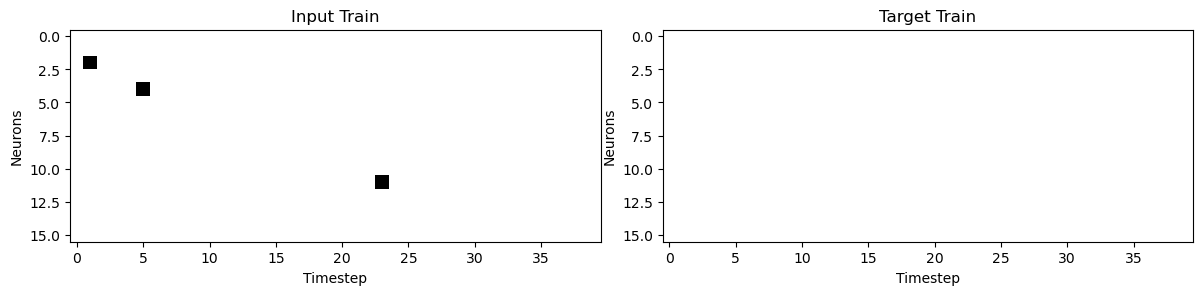

In [123]:
ind=0
for batch in train_loader:
    
    print("data")
    print(batch["data"][ind])
    print("target")
    print(batch["target"][ind])
    
    
    spike = custom_spikegen(batch["data"],40)
    spike_t = custom_spikegen(batch["target"],40)
    
    spike_in = spike.view(40, batch_size, -1)
    spike_target = spike_t.view(40, batch_size, -1)
    
    train_visualization(torch.transpose(spike_in[:,ind,:],0,1),torch.transpose(spike_target[:,ind,:],0,1))
    
    break

## NETWORK

In [130]:
# Network Architecture
num_inputs = ps.NLAYERS*ps.NWIRES
num_hidden = 100
num_outputs = num_inputs

# Temporal Dynamics
num_steps = 40
beta = 0.8
alpha = 0.8

In [135]:
class Net2order(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps):
        super().__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Synaptic(beta=beta,alpha=alpha,
                                   spike_grad=spike_grad,
                                   threshold=3.5)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Synaptic(beta=beta,alpha=alpha,
                                    spike_grad=spike_grad,
                                    threshold=3.5,reset_mechanism = 'zero')
        
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        syn1, mem1 = self.lif_in.init_synaptic()
        syn2, mem2 = self.lif_out.init_synaptic()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
            cur1 = self.fc_in(x[step])
            spk1, syn1, mem1 = self.lif_in(cur1, syn1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, syn2, mem2 = self.lif_out(cur2, syn2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

net = Net2order(num_inputs, num_hidden, num_outputs, num_steps).to(device)

In [136]:
num_epochs = 5
loss_hist = []
iter_counter = 0

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))


# Outer training loop
for epoch in range(num_epochs):
    
    batch_counter = 0
    # Minibatch training loop
    for batch in train_loader:
        net.train()
        
        data_it = batch["data"].to(device)
        targets_it = batch["target"].to(device)

        # create spike train
        spike_in = custom_spikegen(data_it, num_steps)
        spike_targets = custom_spikegen(targets_it, num_steps)

        spike_in = spike_in.to(device)
        spike_targets = spike_targets.to(device)
        
        
        # forward pass
        spk_rec, mem_rec = net(spike_in.view(num_steps, batch_size, -1))
        
        loss_val = torch.tensor(0.)
        for step in range(num_steps):
            loss_val += loss_fn(spk_rec.view(num_steps, batch_size, -1)[step], spike_targets.view(num_steps, batch_size, -1)[step])
            
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())
        
        if iter_counter % 50 == 0:
            print("Epoch:",epoch)
            print("Batch:",batch_counter)
            print("Iteration:",iter_counter)
            print("Loss:",loss_val.item(),"\n")
        
        batch_counter += 1
        iter_counter += 1

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.0043750000186264515 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.004999999888241291 

Epoch: 1
Batch: 0
Iteration: 100
Loss: 0.0 

Epoch: 1
Batch: 50
Iteration: 150
Loss: 0.0018749999580904841 

Epoch: 2
Batch: 0
Iteration: 200
Loss: 0.0 

Epoch: 2
Batch: 50
Iteration: 250
Loss: 0.0 

Epoch: 3
Batch: 0
Iteration: 300
Loss: 0.009999999776482582 

Epoch: 3
Batch: 50
Iteration: 350
Loss: 0.0024999999441206455 

Epoch: 4
Batch: 0
Iteration: 400
Loss: 0.0043750000186264515 

Epoch: 4
Batch: 50
Iteration: 450
Loss: 0.00687499949708581 



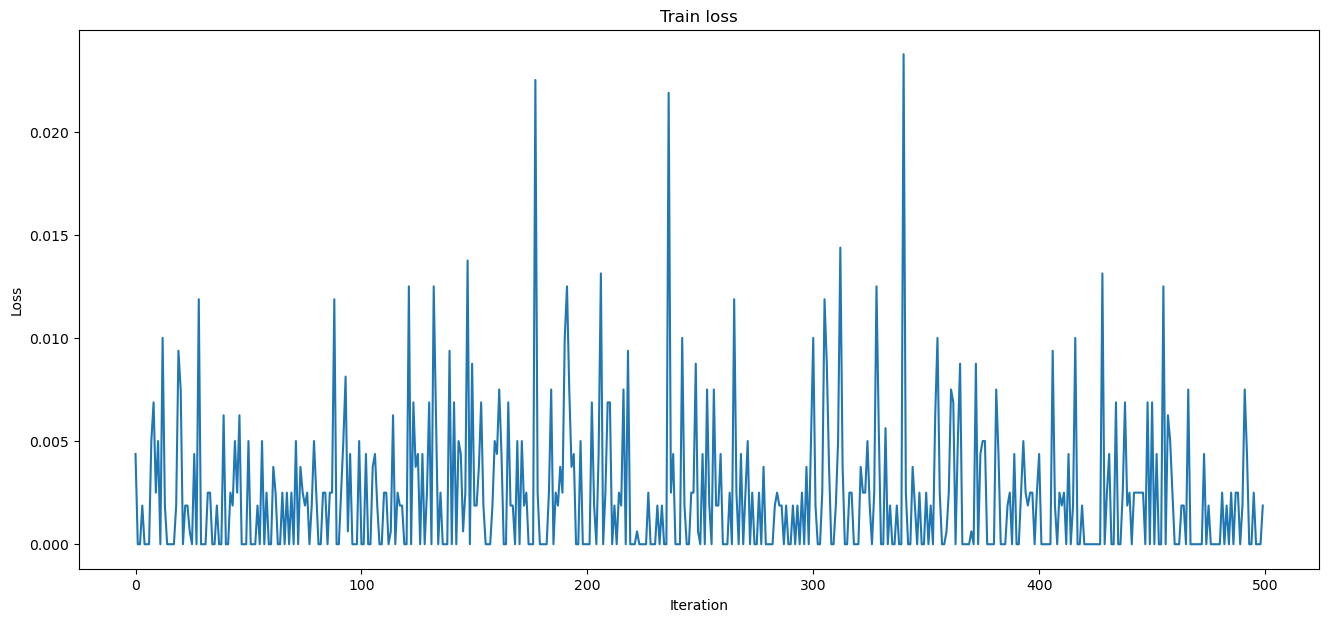

In [137]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(16, 7))
plt.plot(loss_hist)
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()